<a href="https://colab.research.google.com/github/DaryaVish/first-project/blob/main/%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D1%80%D0%B8%D1%81%D0%BA%D0%B0_%D0%94%D0%A2%D0%9F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Оценка риска ДТП



Создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.
Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.
Идея решения задачи от заказчика:
Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
Для модели выбрать тип виновника — только машина (car).
Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
Для моделирования ограничиться данными за 2012 год — они самые свежие.
Обязательное условие — учесть фактор возраста автомобиля.
На основе модели исследовать основные факторы ДТП.
Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
Какие ещё факторы нужно учесть?
Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?
Заказчик предлагает вам поработать с базой данных по происшествиям и сформировать свои идеи создания такой системы.

**Краткое описание таблиц**

collisions — общая информация о ДТП

Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.

parties — информация об участниках ДТП

Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.

vehicles — информация о пострадавших машинах. Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties.


In [1]:
! pip install -q sqlalchemy
! pip install -q catboost
! pip install -q ydata_profiling
! pip install -q lightgbm
! pip install -q Phik

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import missingno as msno
from sqlalchemy import create_engine
import seaborn as sns
import phik


from catboost import CatBoostClassifier
from catboost import Pool, cv
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyRegressor


from scipy.stats import uniform
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (train_test_split, RandomizedSearchCV)
from sklearn.preprocessing import (
    OrdinalEncoder,
    StandardScaler,
    OneHotEncoder
)



import warnings
warnings.filterwarnings("ignore")


RANDOM_STATE = 42
pd.reset_option('max_columns', 35)

## Подключитесь к базе. Загрузите таблицы sql

In [3]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
}

In [4]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)


engine = create_engine(connection_string)

Выгрузим таблицу collisions для первичного ознакомления

In [5]:
query = '''
SELECT *
FROM collisions
LIMIT 5
'''

collisions = pd.read_sql_query(query, con = engine)

Выгрузим таблицу parties для первичного ознакомления

In [6]:
query = '''
SELECT *
FROM parties
LIMIT 5
'''

parties = pd.read_sql_query(query, con = engine)

Выгрузим таблицу vehicles для первичного ознакомления

In [7]:
query = '''
SELECT *
FROM vehicles
LIMIT 5
'''

vehicles = pd.read_sql_query(query, con = engine)

Выгрузим таблицу case_ids для первичного ознакомления

In [8]:
query = '''
SELECT *
FROM case_ids
LIMIT 5
'''

case_ids = pd.read_sql_query(query, con = engine)

In [9]:
query = '''
SELECT table_name
FROM information_schema.tables
WHERE table_schema='public'
'''

table = pd.read_sql_query(query, con = engine)

In [10]:
table

,table_name
0,case_ids
1,collisions
2,parties
3,vehicles


## Проведите первичное исследование таблиц

Взглянем на выгруженные таблицы, ознакомимся с признаками для будующей модели

In [11]:
collisions

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [12]:
parties

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


In [13]:
vehicles

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


In [14]:
case_ids

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


In [15]:
case_ids['db_year'].unique()

array(['2021'], dtype=object)

Во всех таблицах есть общий ключ case_id по которому можно соединить их в одну и выгрузить только нужные и информативные признаки для дальнейшего построения модели.
Таблица case_ids состоит из двух столбцов - id ДТП и 2021 года в строковом формате, эту таблицу использовать не будем так как информативных данных необходимых для модели она не содержит.

##  Проведите статистический анализ факторов ДТП

1. Проанализируем в какие месяцы происходит больше всего аварий

In [16]:
query = '''
SELECT COUNT(CASE_ID) as count_dtp,
       EXTRACT(MONTH FROM collision_date) as month_collision
FROM collisions
GROUP BY month_collision
ORDER BY COUNT(CASE_ID)DESC;
'''


In [17]:
month_collision = pd.read_sql_query(query, con = engine)

In [18]:
month_collision = month_collision.astype('int32')
month_collision

,count_dtp,month_collision
0,139581,3
1,132044,1
2,130316,5
3,130180,4
4,128858,2
5,112237,10
6,107945,12
7,105159,9
8,104770,11
9,104089,8


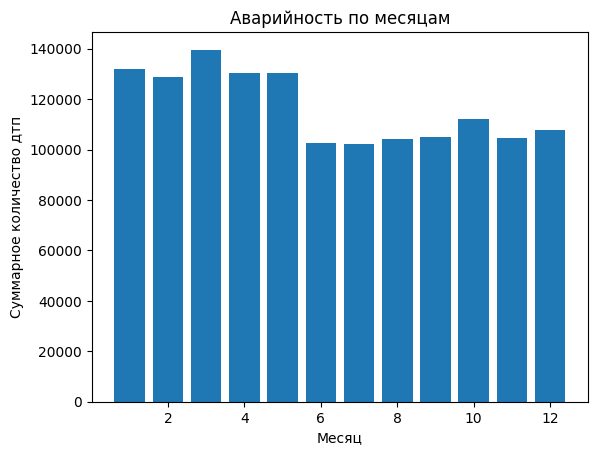

In [19]:
plt.title('Аварийность по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Суммарное количество дтп')
plt.bar(month_collision['month_collision'], month_collision['count_dtp']);

Март - самый аварийный месяц - за весь период в марте произошло 140 тысяч дтп, немного отстают январь, апрель, май - около 130 тысяч и февраль. Наименее аварийные июнь и июль - 100 тысяч дтп.

Проанализируем год

In [20]:

query = '''
SELECT COUNT(CASE_ID) as count_dtp,
       EXTRACT(YEAR FROM collision_date) as year_collision
FROM collisions
GROUP BY year_collision
ORDER BY COUNT(CASE_ID)DESC;
'''


In [21]:
year_collision = pd.read_sql_query(query, con = engine)

In [22]:
year_collision = year_collision.astype('int32')
year_collision

,count_dtp,year_collision
0,426228,2009
1,416490,2010
2,402428,2011
3,154547,2012
4,305,2013
5,2,2020


Таблицы хранят данные о ДТП с 2009 по 2013 года и 2 записи о 2020 годе.

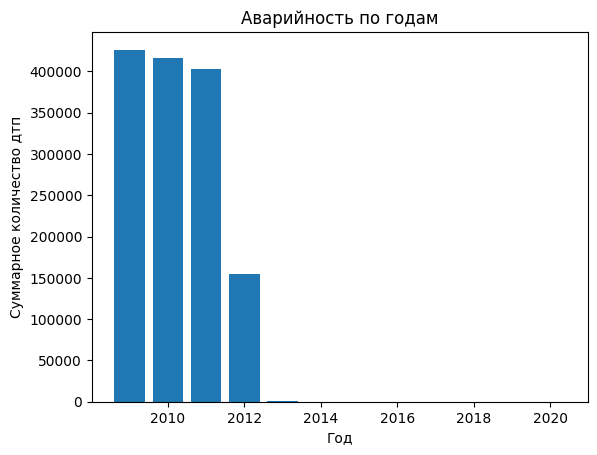

In [23]:
plt.title('Аварийность по годам')
plt.xlabel('Год')
plt.ylabel('Суммарное количество дтп')
plt.bar(year_collision['year_collision'], year_collision['count_dtp']);

Заказчик просит проанализировать данные только за 2012 год, что возможно не вполне логично, так как большее количество наблюдений собрано за 2009-2011 года.

**Задачи:**


1. Проанализировать состояние дорожного покрытия(collisions) в момент дтп между автомобилями(parties):


*   Создайте sql-запрос;
*   Постройте график;
*   Сделайте вывод;

2. Проанализировать как погодные условия влияют на основной фактор аварии(collisions);
3. Проанализаровать в каких районах сосредоточено максимальное количество ДТП и степень серьёзности повреждений(collisions);
4. Проанализировать как освещенность влияет на основной фактор аварии(collisions);
5. Проанализировать какое соотношение происшествий с участием автомобилей(parties) происходит на перекрестках и шоссе (collisions):

*   Создайте sql-запрос;
*   Постройте график;
*   Сделайте вывод;

6. Найти самые частые причины дтп(collisions).



**Решим прописанную задачу 1.**

Задача проанализировать состояние дорожного покрытия(collisions) в момент дтп между автомобилями(parties):

* Создайте sql-запрос;
* Постройте график;
* Сделайте вывод;

In [24]:
query = '''
with road_surface as(SELECT COUNT(col.case_id) as count_dtp,
                          part.party_type,
                          col.road_surface
                    FROM collisions as col
                    LEFT JOIN parties as part ON col.case_id = part.case_id
                    WHERE part.party_type != 'None' and road_surface != 'None'
                    GROUP BY col.road_surface, part.party_type
                    ORDER BY (count_dtp)DESC)
SELECT *
FROM road_surface
WHERE party_type = 'car';
'''

query_1 = pd.read_sql_query(query, con = engine)

In [25]:
query_1

,count_dtp,party_type,road_surface
0,2210553,car,dry
1,224703,car,wet
2,9875,car,snowy
3,1984,car,slippery


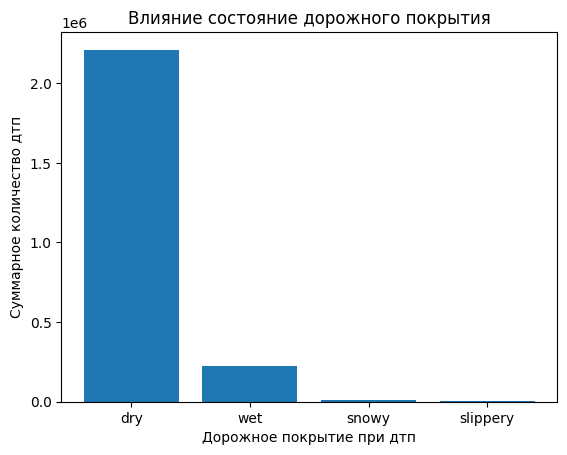

In [26]:
plt.title('Влияние состояние дорожного покрытия')
plt.xlabel('Дорожное покрытие при дтп')
plt.ylabel('Суммарное количество дтп')
plt.bar(query_1['road_surface'], query_1['count_dtp']);

С полной уверенностью можно сказать, что дтп на влажной и обледенелой дороге происходят реже, водители ездят осторожнее. Количество дтп на сухом дорожном покрытии составляет свыше 2 млн 200 тысяч, а на влажном дорожном покрытии - 224 тысячи.

**Решим прописанную задачу 5.**

5. Проанализировать какое соотношение происшествий с участием автомобилей(parties) происходит на перекрестках и шоссе (collisions):

*   Создайте sql-запрос;
*   Постройте график;
*   Сделайте вывод;


In [27]:
query = '''
WITH  intersection_case as (SELECT COUNT(col.case_id) as count_dtp,
                                   part.party_type,
                                   col.location_type
                            FROM collisions as col
                            LEFT JOIN parties as part ON col.case_id = part.case_id
                            WHERE part.party_type != 'None' AND part.party_type = 'car'
                            GROUP BY col.location_type, part.party_type
                            ORDER BY (count_dtp)DESC)
SELECT count_dtp,
       location_type
FROM intersection_case
WHERE location_type is not null AND location_type != 'ramp';
'''

query_2 = pd.read_sql_query(query, con = engine)

In [28]:
query_2

,count_dtp,location_type
0,822271,highway
1,50343,intersection


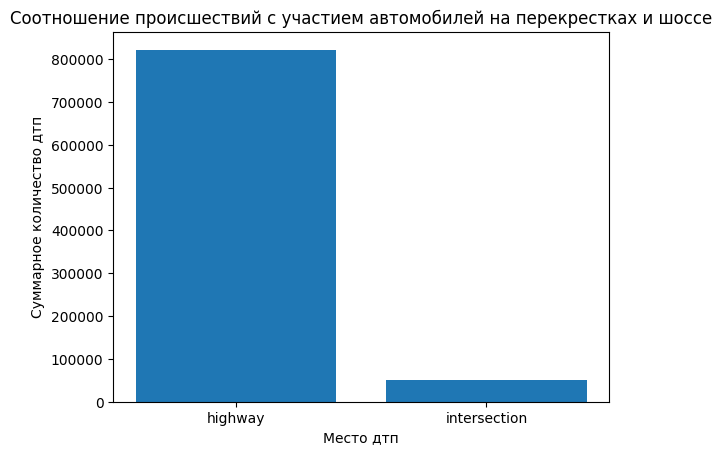

In [29]:
plt.title('Cоотношение происшествий с участием автомобилей на перекрестках и шоссе')
plt.xlabel('Место дтп')
plt.ylabel('Суммарное количество дтп')
plt.bar(query_2['location_type'], query_2['count_dtp']);

Чаще всего происшествия регистрируются на шоссе - свыше 820 случаев и только 50 тысяч аварий происходят на перекрестках

In [30]:
query = '''
WITH  car_case as (SELECT col.direction, col.weather_1,
                          col.county_city_location,
                          col.road_surface, col.road_condition_1,
                          col.lighting,
                          part.party_type, part.at_fault,
                          part.party_sobriety, col.collision_damage,
                          part.party_drug_physical, part.cellphone_in_use,
                          veh.vehicle_type, veh.vehicle_transmission,
                          veh.vehicle_age, col.collision_date
                   FROM collisions as col
                   JOIN parties as part ON col.case_id = part.case_id
                   JOIN vehicles as veh ON col.case_id = veh.case_id and part.party_number = veh.party_number
                   WHERE part.party_type != 'None' AND part.party_type = 'car'),

       query as   (SELECT weather_1, lighting,
                          road_surface, road_condition_1,
                          direction, at_fault, county_city_location,
                          party_sobriety, collision_damage,
                          party_drug_physical, cellphone_in_use,
                          vehicle_type, vehicle_transmission,
                          vehicle_age, collision_date,
                          EXTRACT(DOW FROM collision_date)::int as day_of_week
                    FROM car_case
                    WHERE collision_damage != 'scratch' AND collision_date BETWEEN '2012-01-01' AND '2012-12-31')

SELECT weather_1, lighting,
       road_surface, road_condition_1,
       direction, at_fault, county_city_location,
       vehicle_type, vehicle_transmission,
       vehicle_age, day_of_week
FROM query;
'''

df = pd.read_sql_query(query, con = engine)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   weather_1             56080 non-null  object 
 1   lighting              56094 non-null  object 
 2   road_surface          55900 non-null  object 
 3   road_condition_1      55999 non-null  object 
 4   direction             43230 non-null  object 
 5   at_fault              56248 non-null  int64  
 6   county_city_location  56248 non-null  object 
 7   vehicle_type          56248 non-null  object 
 8   vehicle_transmission  55389 non-null  object 
 9   vehicle_age           54554 non-null  float64
 10  day_of_week           56248 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 4.7+ MB


In [32]:
df.columns

Index(['weather_1', 'lighting', 'road_surface', 'road_condition_1',
       'direction', 'at_fault', 'county_city_location', 'vehicle_type',
       'vehicle_transmission', 'vehicle_age', 'day_of_week'],
      dtype='object')

Удалим признак с датой, серьёзностью ущерба и местом аварии.

In [33]:
df

,weather_1,lighting,road_surface,road_condition_1,direction,at_fault,county_city_location,vehicle_type,vehicle_transmission,vehicle_age,day_of_week
0,clear,daylight,dry,normal,east,1,3700,coupe,auto,13.0,4
1,clear,daylight,dry,normal,north,0,1900,sedan,manual,3.0,0
2,clear,daylight,dry,normal,south,1,1985,coupe,auto,11.0,2
3,clear,dark with street lights,dry,normal,None,1,0112,coupe,manual,6.0,3
4,clear,dark with no street lights,dry,normal,south,0,2900,coupe,manual,6.0,4
...,...,...,...,...,...,...,...,...,...,...,...
56243,clear,dark with street lights,dry,normal,None,0,3605,sedan,auto,2.0,3
56244,clear,daylight,dry,normal,None,1,1931,sedan,auto,4.0,3
56245,clear,daylight,dry,normal,None,0,1931,coupe,auto,4.0,3
56246,clear,daylight,dry,normal,None,1,3012,coupe,auto,11.0,6


Еще при выгрузке sql запросов я заметила достаточно много пропущенных значений. Построим матрицу пропусков из библиотеки Missingno для наглядности

<Axes: >

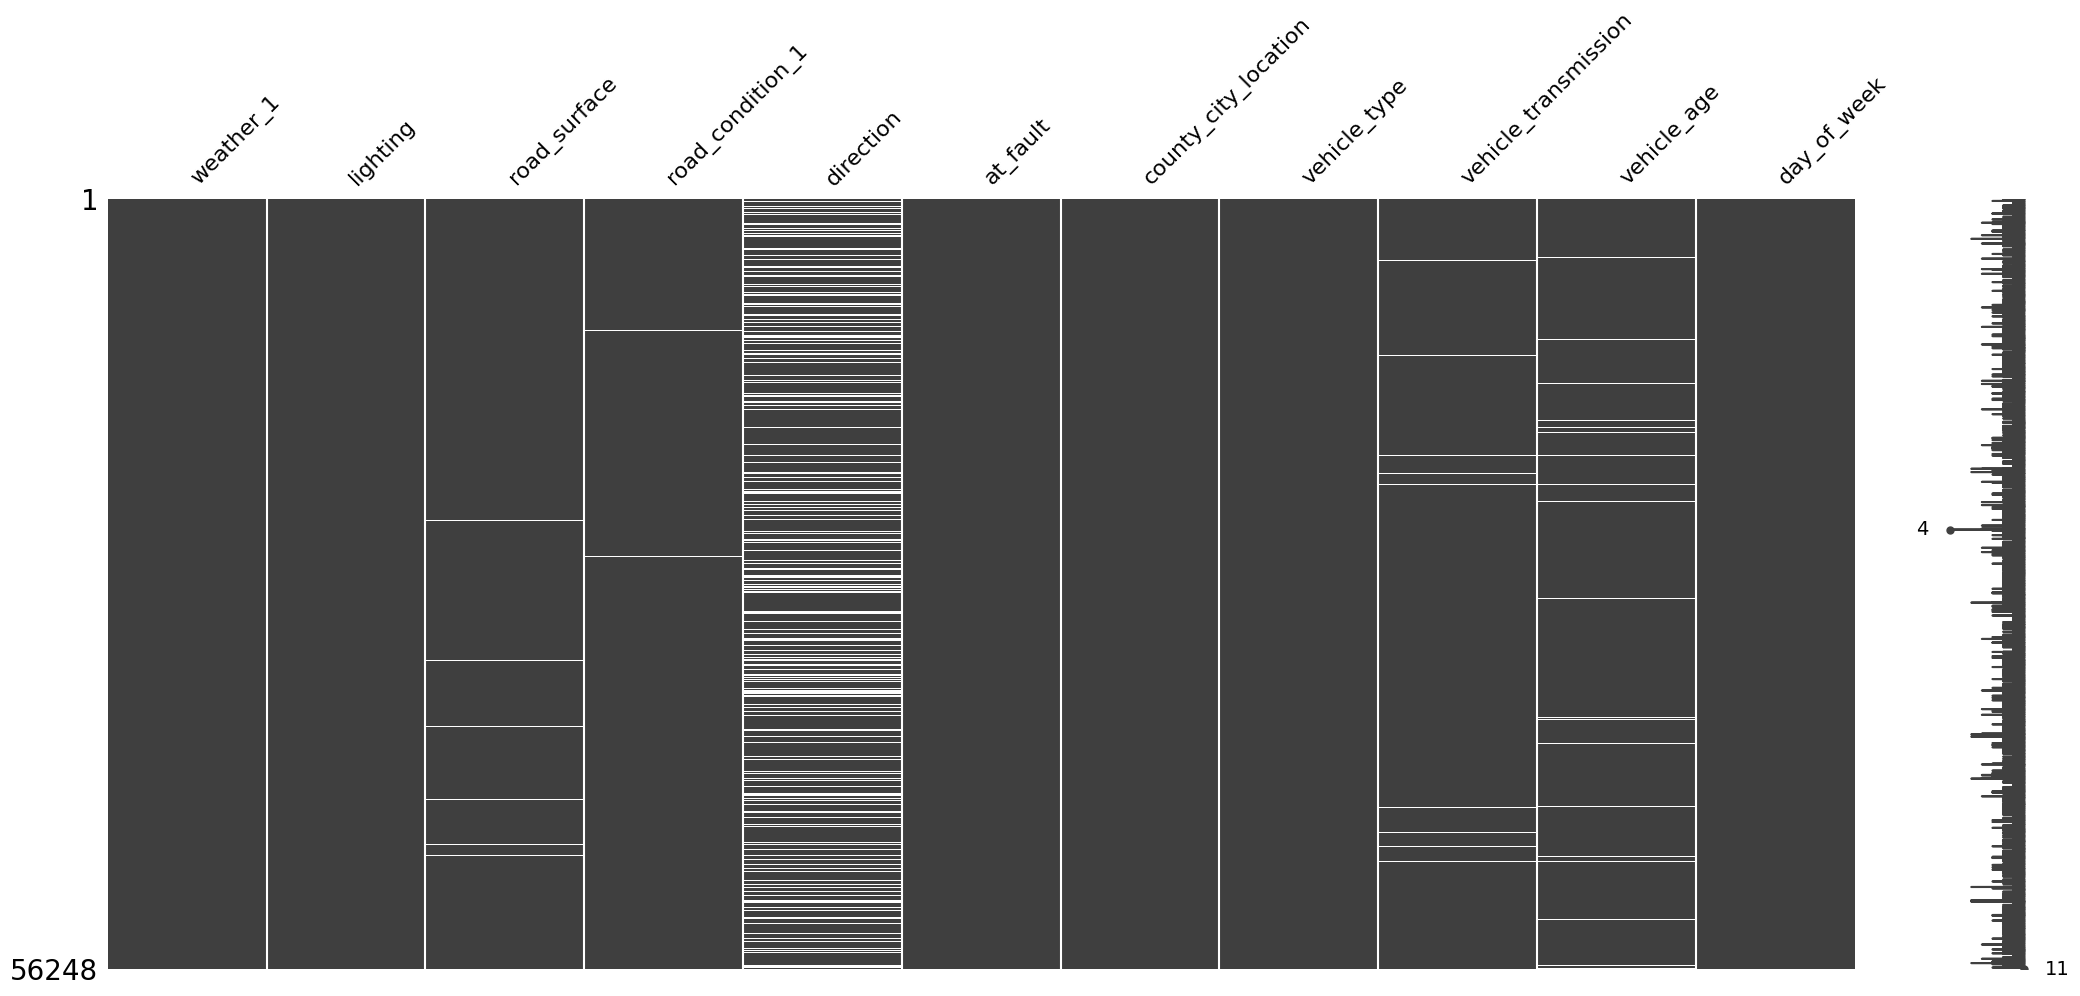

In [34]:
msno.matrix(df)

признак party_drug_physical (cостояние участника: физическое или с учётом принятых лекарств) содержат в себе очень большое количество пропусков. Поставим на места пропусков в датафрейме заглушку 'unknown'

Наглядно выведем соотношение классов в задаче

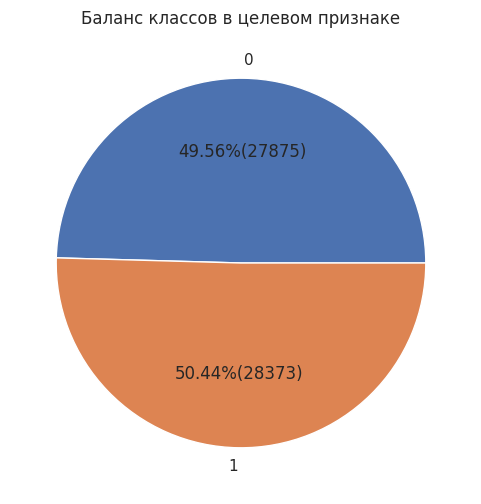

In [35]:
ratio = df.groupby('at_fault').size()

sns.set()
ratio.plot(kind='pie', title='Баланс классов в целевом признаке', figsize=[6,6],
          autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*ratio.sum()))
plt.show()

А day_of_week в строковый тип

In [36]:
df['day_of_week'] = df['day_of_week'].astype(object)

приведем к типу bool целевой признак 'at_fault'

In [37]:
df.at_fault = df.at_fault.astype(bool)

Разделим датасет на выборки, модели будем использовать с GridSerchCV поэтому в валидационной нет необходимости

In [38]:
X_train, X_test = train_test_split(df, test_size=0.25, random_state=RANDOM_STATE, shuffle=True, stratify=df.at_fault)
print(X_train.shape)
print(X_test.shape)

(42186, 11)
(14062, 11)


In [39]:
X_train.vehicle_age.value_counts()

,count
vehicle_age,
3.0,8240
4.0,5421
2.0,4480
5.0,4176
6.0,2943
7.0,2919
8.0,2659
0.0,2316
9.0,2076


Обнаружены выбросы в vehicle_age в train.

In [40]:
X_train = X_train.loc[X_train['vehicle_age'] != 161]

In [41]:
X_train.vehicle_age = X_train.vehicle_age.fillna(X_train.vehicle_age.median())
X_test.vehicle_age = X_test.vehicle_age.fillna(X_train.vehicle_age.median())

In [42]:
print(X_train.vehicle_age.isna().sum())
print(X_test.vehicle_age.isna().sum())

0
0


Проведем анализ важности фичей с помощью Phik

In [43]:
phik_overview = X_train.phik_matrix(interval_cols=['vehicle_age'])

In [44]:
phik_overview['at_fault'].sort_values(ascending=False)

,at_fault
at_fault,1.000000
vehicle_age,0.172637
county_city_location,0.149927
vehicle_transmission,0.140334
vehicle_type,0.098909
road_surface,0.094262
lighting,0.073235
weather_1,0.044938
day_of_week,0.027369
road_condition_1,0.025755


Исходя из анализа Phik вот топ-5 ключевых факторов влияющих на на вероятность ДТП

* vehicle_age	0.176791 - Возраст автомобиля
* county_city_location	0.153809 - Код местоположения
* vehicle_transmission	0.143115 - Тип коробки передач
* vehicle_type	0.099182 - Тип кузова
* road_surface	0.094835	0.09717 - Состояние дорожного покрытия



Заменим пропущенные значения заглушкой unknown

In [45]:
X_train = X_train.fillna('unknown')
X_test = X_test.fillna('unknown')

In [46]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42186 entries, 35674 to 55795
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   weather_1             42186 non-null  object 
 1   lighting              42186 non-null  object 
 2   road_surface          42186 non-null  object 
 3   road_condition_1      42186 non-null  object 
 4   direction             42186 non-null  object 
 5   at_fault              42186 non-null  bool   
 6   county_city_location  42186 non-null  object 
 7   vehicle_type          42186 non-null  object 
 8   vehicle_transmission  42186 non-null  object 
 9   vehicle_age           42186 non-null  float64
 10  day_of_week           42186 non-null  int64  
dtypes: bool(1), float64(1), int64(1), object(8)
memory usage: 3.6+ MB


In [47]:
y_train = X_train.at_fault

In [48]:
X_train.drop('at_fault', axis=1, inplace=True)

In [49]:
X_train.columns

Index(['weather_1', 'lighting', 'road_surface', 'road_condition_1',
       'direction', 'county_city_location', 'vehicle_type',
       'vehicle_transmission', 'vehicle_age', 'day_of_week'],
      dtype='object')

In [50]:
y_test = X_test.at_fault

In [51]:
X_test.drop('at_fault', axis=1, inplace=True)

In [52]:
X_test.columns

Index(['weather_1', 'lighting', 'road_surface', 'road_condition_1',
       'direction', 'county_city_location', 'vehicle_type',
       'vehicle_transmission', 'vehicle_age', 'day_of_week'],
      dtype='object')

## Создайте модель для оценки водительского риска


В качестве метрики для оценки моделей я буду использовать одну из главных метрик подходящих для задач бинарной классификации - auc-roc, так как она оценивает способность модели различать два класса при разных уровнях порога классификации.

**CatBoost**

In [53]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42186 entries, 35674 to 55795
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   weather_1             42186 non-null  object 
 1   lighting              42186 non-null  object 
 2   road_surface          42186 non-null  object 
 3   road_condition_1      42186 non-null  object 
 4   direction             42186 non-null  object 
 5   county_city_location  42186 non-null  object 
 6   vehicle_type          42186 non-null  object 
 7   vehicle_transmission  42186 non-null  object 
 8   vehicle_age           42186 non-null  float64
 9   day_of_week           42186 non-null  int64  
dtypes: float64(1), int64(1), object(8)
memory usage: 3.5+ MB


Чтобы не возникло путаницы с типом признаков, укажем их названия вручную

In [54]:
num_features = ['vehicle_age']

Создадим список категориальных столбцов для CatBoost

In [55]:
cat_features = ['weather_1', 'road_surface',
       'lighting', 'direction', 'vehicle_transmission',
       'county_city_location', 'vehicle_type',
       'road_condition_1', 'day_of_week']

С помощью кросс-валидации подбрём лучшие параметры

In [56]:
train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features
                 )

In [57]:
params = {
          'loss_function': 'Logloss',
          'eval_metric': 'AUC',
              'learning_rate': 0.04,
              'random_seed': 42,
              'verbose':100}

In [58]:
cv_data = cv(
    params = params,
    pool = train_data,
    fold_count=5,
    shuffle=True,
    partition_random_seed=42,
    stratified=False,
    verbose=False,
    early_stopping_rounds=200
)

Training on fold [0/5]

bestTest = 0.6824659382
bestIteration = 974

Training on fold [1/5]

bestTest = 0.6641642947
bestIteration = 985

Training on fold [2/5]

bestTest = 0.6684437927
bestIteration = 953

Training on fold [3/5]

bestTest = 0.6725962093
bestIteration = 850

Training on fold [4/5]

bestTest = 0.6754015724
bestIteration = 869



In [59]:
cv_data.head()

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.634021,0.007815,0.690536,0.000123,0.690512,0.000052
1,1,0.641130,0.008438,0.688046,0.000227,0.687980,0.000197
2,2,0.641879,0.008207,0.685744,0.000312,0.685628,0.000284
3,3,0.642448,0.008414,0.683692,0.000464,0.683530,0.000383
4,4,0.642723,0.008384,0.681873,0.000687,0.681681,0.000329


In [60]:
cv_data[cv_data['test-AUC-mean'] == cv_data['test-AUC-mean'].max()]

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
969,969,0.672525,0.006969,0.642854,0.004006,0.616445,0.000896


In [61]:
model_CBCl_best_score = np.mean(cv_data['test-AUC-mean'])
print("Best validation AUC score: {:.4f}".format(
model_CBCl_best_score))

Best validation AUC score: 0.6662


Сначала я отобралала для обучения бустинговой модели только эти признаки, они показались мне наиболее важными:
'county_city_location',
'primary_collision_factor',
'pcf_violation_category',
'type_of_collision',
'motor_vehicle_involved_with',
'insurance_premium',
'party_sobriety' исходя из того, что необходимо применить модель к маршрутут следования арендатора авто. Метрика roc-auc составила всего 0.436. Стало ясно, что для обучения необходимо больше признаков, так как модели сложно увидеть зависимость между разрозненными данными. Поэтому я обучила модель уже на всех признаках включая id происшествия и id пострадавших машин в ДТП. Добавила признак day_of_week для поиска зависимости между количествои дтп и днем недели и убрала признаки с датой и временем происшествия. С помощью Catboost удалось достичь roc-auc 0.9920 на кросс-валидации.

**LogisticRegressionCV**

Используем OHE и StandardScaler для линейной модели

In [62]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown = 'ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

X_train_OHE = preprocessor.fit_transform(X_train)
X_test_OHE = preprocessor.transform(X_test)

Обучим регрессионную модель

In [63]:
logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,
                              random_state=RANDOM_STATE)
distributions = dict(C=uniform(loc=0, scale=4),
                     penalty=['l2', 'l1'])
clf = RandomizedSearchCV(logistic, distributions, random_state=0, cv=5, scoring='roc_auc')
search = clf.fit(X_train_OHE, y_train)
best_params = search.best_params_
model_Log_Reg_auc = search.best_score_

**RandomForestClassifier**

In [64]:
col_transformer_rf= make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        cat_features

    ),
    (
        StandardScaler(),
        num_features
    )
)

In [65]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)

pipline_rf = make_pipeline(col_transformer_rf, model_rf)

param_grid_rf = {
    'randomforestclassifier__n_estimators': range(50, 251, 50),
    'randomforestclassifier__max_depth': range(2, 15, 1)
}


gs_rf = RandomizedSearchCV(
    pipline_rf,
    param_distributions=param_grid_rf,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

gs_rf.fit(X_train, y_train)

model_RFC_auc = gs_rf.best_score_
gs_rf_best_params = gs_rf.best_params_
print(f'best_params: {gs_rf_best_params}')

best_params: {'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__max_depth': 8}


Сравним в таблице все результаты

In [66]:
model_data = {
'model_name': ['CatBoost', 'LogisticRegression', 'RandomForestClassifier'],
'AUC': [model_CBCl_best_score, model_Log_Reg_auc, model_RFC_auc]
}

model_table = pd.DataFrame.from_dict(model_data)
model_table

,model_name,AUC
0,CatBoost,0.666208
1,LogisticRegression,0.631174
2,RandomForestClassifier,0.649198


**Вывод**

Лучшей моделью оказась CatBoost, она немного опередила RandomForest и логистическую регрессию, ее и будем проверять на тестовой выборке.

## Проведите анализ важности факторов ДТП

## Проверка лучшей модели на test

Лучший скор показала модель CatBoost, ее и будем проверять на тесте

In [67]:
params = {
          'loss_function': 'Logloss',
          'eval_metric': 'AUC',
              'learning_rate': 0.07,
              'random_seed': 42,
              'verbose':100}

In [68]:
model_CBCl = CatBoostClassifier(**params)

In [69]:
model_CBCl.fit(train_data)

0:	total: 105ms	remaining: 1m 45s
100:	total: 8.72s	remaining: 1m 17s
200:	total: 17.9s	remaining: 1m 11s
300:	total: 27.6s	remaining: 1m 4s
400:	total: 37.4s	remaining: 55.9s
500:	total: 46s	remaining: 45.8s
600:	total: 55.9s	remaining: 37.1s
700:	total: 1m 5s	remaining: 28.1s
800:	total: 1m 15s	remaining: 18.8s
900:	total: 1m 24s	remaining: 9.27s
999:	total: 1m 35s	remaining: 0us


In [70]:
X_test['score_catboost'] = model_CBCl.predict_proba(X_test)[:,1]

In [71]:
X_test['y_pred'] = model_CBCl.predict(X_test)

In [72]:
print(classification_report(y_test, X_test['y_pred']))

              precision    recall  f1-score   support

       False       0.61      0.71      0.66      6969
        True       0.66      0.55      0.60      7093

    accuracy                           0.63     14062
   macro avg       0.64      0.63      0.63     14062
weighted avg       0.64      0.63      0.63     14062



In [73]:
roc_auc_score(y_test, X_test['score_catboost'])

0.6889887598534341

Auc-roc на тестовой выборке 0.67, что говорит о неплохой предсказательной возможности бустиноговой модели.

Предскажем ответ с помощью константной модели

In [74]:
dummy_regr = DummyRegressor(strategy="mean").fit(X_train, y_train)
y_pred = dummy_regr.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC для DummyRegressor: {roc_auc}")

ROC-AUC для DummyRegressor: 0.5


Как и полагается константная модель предсказывает хуже обученной Catboost и auc-roc метрика у нее 0.5 против 0.67

Взглянем на матрицу ошибок лучшей модели, обученной на тестовом наборе данных

In [75]:
confusion_matrix(y_test, X_test['y_pred'])

array([[4958, 2011],
       [3173, 3920]])

Модель лучше определяет невиновных в аварии - 4 тысячи 635 правильных ответов у нее на счету, а вот с единицами, то есть с предсказанием реальных виновников она путается. К реально существующим виновникам в количестве 4139 она прибавляет ещё 2954, то есть увеличивает их. И 2334 остаётся на ложно негативные ответы - то есть это виновники, которых модель размечает как невиновных.

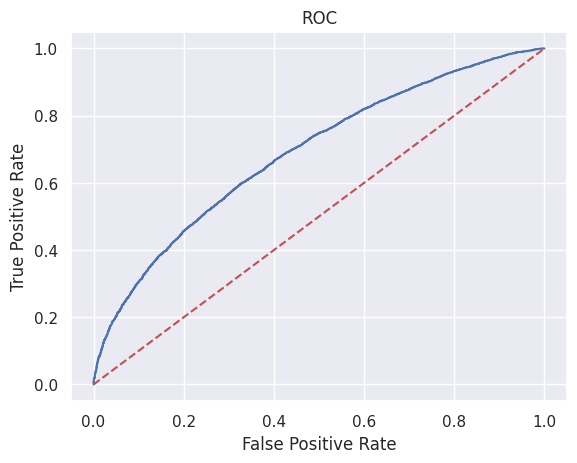

In [76]:
fpr, tpr, _ = metrics.roc_curve(y_test,  X_test['score_catboost'])

# построение ROC кривой
plt.title('ROC')
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0, 1], [0, 1],'r--')
plt.show()

График подтверждает матрицу ошибок

**Проведем анализ важности фичей уже после обучения модели**

Воспользуемся методом get_feature_importance встроенным в Catboost и посмотрим какие фичи именно Catboost посчитал самыми важными

In [77]:
model_CBCl.get_feature_importance(prettified=True)

,Feature Id,Importances
0,county_city_location,19.307109
1,vehicle_age,16.002143
2,direction,12.604224
3,vehicle_type,10.170542
4,day_of_week,9.765247
5,lighting,8.741250
6,weather_1,6.739646
7,vehicle_transmission,6.380397
8,road_surface,5.260419
9,road_condition_1,5.029023


Топ-6 фичей по важности:

1)	county_city_location - код региона

2)	vehicle_age - возраст автомобиля

3)	direction	-  направление движения

4)	 vehicle_type	- тип кузова

5) day_of_week - день недели

6)	lighting - освещение



Исследуем тип кузова в разрезе целевого признака

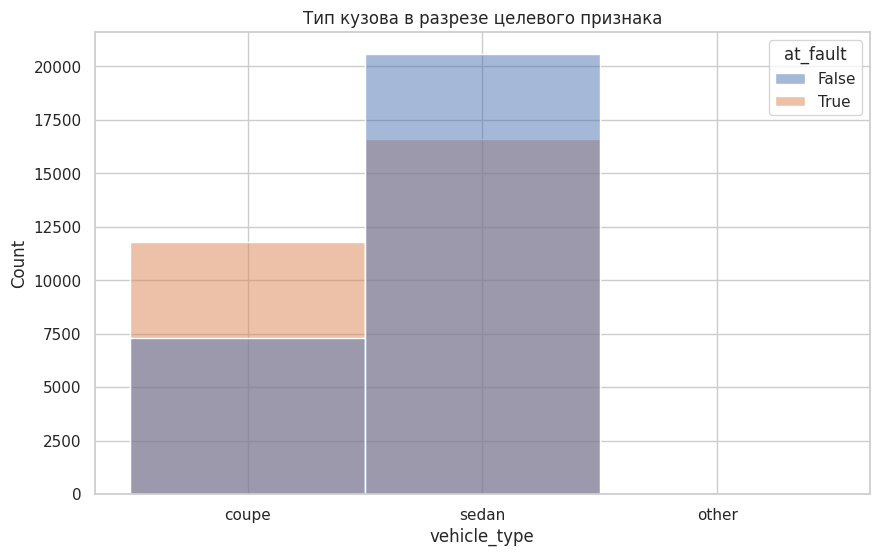

In [78]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='vehicle_type', hue='at_fault', bins=10)
plt.title('Тип кузова в разрезе целевого признака')
plt.show()


В автомобилях типа купе (двухдверных) виновность в аварии в процентном соотношении выше, чем в седанах и авто другого типа. Можно в данном случае рекомендовать снизить количество авто типа купе в шеринге или повысить на их аренду цену, чтобы искуственно повысить спрос на другие автомобили.


## Выводы

Сначала я отобралала для обучения бустинговой модели только эти признаки, они показались мне наиболее важными: 'county_city_location', 'primary_collision_factor', 'pcf_violation_category', 'type_of_collision', 'motor_vehicle_involved_with', 'insurance_premium', 'party_sobriety' исходя из того, что необходимо применить модель к маршрутут следования арендатора авто. Метрика roc-auc составила всего 0.436. Стало ясно, что для обучения необходимо больше признаков, так как модели сложно увидеть зависимость между разрозненными данными. Далее я отобрала для модели воспроизводимые признаки, на момент аренды машины: weather_1, road_surface, road_condition_1, lighting,
       direction, county_city_location, vehicle_type,
       vehicle_transmission, vehicle_age. Добавила признак day_of_week для поиска зависимости между количествои дтп и днем недели. С помощью Catboost удалось достичь roc-auc 0.668 на кросс-валидации. И roc-auc равный 0.672 на test.

Модель лучше определяет невиновных в аварии - 4 тысячи 797 правильных ответов у нее на счету, а вот с единицами, то есть с предсказанием реальных виновников она путается. К реально существующим виновникам в количестве 4117 она прибавляет ещё 2976, то есть увеличивает их. И 2172 остаётся на ложно негативные ответы - то есть это виновники, которых модель размечает как невиновных.

Среди фичей входящих в топ-6 модель выделила:


1)	county_city_location - код региона

2)	vehicle_age - возраст автомобиля

3)	direction -  направление движения

4)	vehicle_type - тип кузова

5) day_of_week - день недели

6)	lighting - освещение




Свыше 42 тысяч виновников попали в ДТП в трезвом состоянии. И только незначительная часть - чуть больше 5 тысяч человек пребывали в состоянии алкогольного опьянения. Всё же я считаю, что оборудование автомобиля датчиком алкогольного опьянения и камерой, чтобы убедиться в том что проверку прошел именно водитель, поможет решить эту проблему. И исключить эти 5-7 тысяч ДТП в год. Также я считаю, что очень важно иметь информацию о стаже водителя и коэффиценте безаварийной езды, и информацию например о том, был ли водитель лишен прав за езду в нетрезвом состоянии.  
Исследование можно дополнить еще поиском взаимосвязи между фактом виновности в аварии и типа кузова - логично предположить, что в высоких машинах лучше обзор и за счет этого они попадают в аварии реже седанов. Возможно если учесть эту гипотезу, то тоже удастся снизить вероятность ДТП, если не закупать седаны для каршеринга.

В автомобилях типа купе (двухдверных) виновность в аварии в процентном соотношении выше, чем в седанах и авто другого типа. Можно в данном случае рекомендовать снизить количество авто типа купе в шеринге или повысить на их аренду цену, чтобы искуственно повысить спрос на другие автомобили.